# Creating comet models - TESS-SPOC

In [1]:
import os, sys
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/stella/')
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/scripts/')
import numpy as np
from utils import *
import build_synthetic_set as models
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob
from tqdm import tqdm
import wotan
import lightkurve as lk
import stella
import pandas as pd
import random

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


### Generate the models

In [12]:
files = glob('../data/tess-spoc/**/*.fits', recursive=True)
len(files)

107973

#### Shuffle

In [3]:
random.shuffle(files)

### Create models

In [4]:
folder = '../tess-spoc-models' # do not add the dash after folder name here as it is done in the loop for saving files

In [6]:
os.makedirs(folder, exist_ok=True)
fails = []
times = []
ticid = []
for i in tqdm(files[0:100]):
    try:
        lc, info = import_lightcurve(i)
        tic = info['TICID']
        flat_flux = wotan.flatten(lc['TIME'], lc['SAP_FLUX'], method='median', window_length=1)
        rms = np.std(flat_flux)
    
        diff = np.diff(lc['TIME'])
        large_gaps_indices = np.where(diff > 1)[0]
    
        min_snr = 5
        max_snr = 20 
        random_snr = np.random.uniform(min_snr,max_snr)
        
        A = rms * random_snr
        
            # Initialize a flag to indicate whether a valid time has been found
        valid_time_found = False
    
        while not valid_time_found:
            t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])
        
            # Check if the current random start time falls within any large gap or within 1.5 days before or after a gap
            for index in large_gaps_indices:
                start_time = lc['TIME'][index] - 1
                end_time = lc['TIME'][index + 1] + 1
                if start_time <= t0 <= end_time:
                    # Current random start time falls within a data gap or within 1.5 days before or after a gap, select a new one
                    break
                elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(t0 - lc['TIME'][index + 1]) < 1.5:
                    # Current random start time is within 1.5 days after a data gap, select a new one
                    break
                elif index > 0 and diff[index - 1] > 0.5 and abs(t0 - lc['TIME'][index]) < 1.5:
                    # Current random start time is within 1.5 days before a data gap, select a new one
                    break
                elif t0 <= lc['TIME'][0] + 1:
                    # Current random start time is within one day after the beginning of the lightcurve, select a new one
                    break
                elif t0 >= lc['TIME'][-1] - 1.5:
                    # Current random start time is within two days before the end of the lightcurve, select a new one
                    break
            else:
                # Current random start time doesn't fall within any data gap, 1.5 days before or after a gap, or special conditions, set the flag to True
                valid_time_found = True


        model = 1 - models.comet_curve(lc['TIME'], A, t0)
        flux = model * flat_flux
        #flux = flux/np.nanmedian(lc['SAP_FLUX'])
        fluxerror = np.array(lc['SAP_FLUX_ERR'] / np.nanmedian(lc['SAP_FLUX']))
    
        time = np.array(lc['TIME'])
        flux = np.array(flux)
        times.append(t0)
        ticid.append(tic)
        np.save(f"{folder}/{info['TICID']}_sector07.npy", np.array([time, flux, fluxerror]))
        #np.save(f"../models/{info['TICID']}_sector28-time.npy", np.array([t0]))
    except TypeError as e:
        fails.append(i)
        print(f"Exception occurred for file {i}: {e}. Continuing...")
        continue

100%|█████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.18it/s]


### Converting non-model lightcurves to `.npy` arrays

Issue: no. of injected lightcurves must be more than test sample

In [5]:
# for i in tqdm(files[10000:20000]):
#     try:
#         lc, info = import_lightcurve(i)
#         tic = info['TICID']
    
#         fluxerror = np.array(lc['SAP_FLUX_ERR'] / np.nanmedian(lc['SAP_FLUX']))

#         time = np.array(lc['TIME'])
#         flux = np.array(lc['SAP_FLUX'] / np.nanmedian(lc['SAP_FLUX']))
#         np.save(f"../models/{info['TICID']}_sector28.npy", np.array([time, flux, fluxerror]))
#     except TypeError:
#         continue

## Sanity check: Read in flare models and plot grid
- numpy files are time, flux (normalised), flux error

In [2]:
flares = glob('../stella-tests/lc/*.npy')
flares[0:5]

[]

In [5]:
# stellas = np.load('../stella-tests/lc/197757864_sector01.npy')
# stellas

In [3]:
file_paths = glob('../stella-tests/lc/*.npy')

num_files_per_grid = 100

# Loop through the file paths in chunks of num_files_per_grid
for i in range(0, len(file_paths), num_files_per_grid):
    batch_paths = file_paths[i:i+num_files_per_grid]
    num_rows, num_cols = 10, 10
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

    for j, path in enumerate(batch_paths):
        file = np.load(path)
        time, flux, fluxerror = file

        # Extract the file ID from the path
        file_id = os.path.splitext(os.path.basename(path))[0].split('_')[0]

        row = j // num_cols
        col = j % num_cols

        axs[row, col].plot(time, flux)
        axs[row, col].set_title(f'TIC {file_id}')

    plt.tight_layout()
    plt.show()
    break

## Loading comet models

In [120]:
comets =  glob('../eleanor-lite-models/*.npy')
comets[0:3]

['../eleanor-lite-models/129085069_sector07.npy',
 '../eleanor-lite-models/125413758_sector07.npy',
 '../eleanor-lite-models/257168170_sector07.npy']

### Sample plot of Full Lightcurves

In [7]:
# num_files_per_grid = 100

# for i in range(0, len(comets), num_files_per_grid):
#     batch_paths = comets[i:i+num_files_per_grid]
#     num_rows, num_cols = 10, 10
#     fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

#     for j, path in enumerate(batch_paths):
#         file = np.load(path,allow_pickle=True)
#         time = file[0]
#         flux = file[1]/np.nanmedian(file[1])


        
#         # Extract the file ID from the path
#         file_id = os.path.splitext(os.path.basename(path))[0].split('_')[0]
        

#         row = j // num_cols
#         col = j % num_cols

#         axs[row, col].plot(time, flux)
#         axs[row, col].set_title(f'TIC {file_id}')

#     plt.tight_layout()
#     plt.show()
#     break

In [23]:
# num_files_per_grid = 25  # Since you want a 5x5 grid

# for i in range(0, len(comets), num_files_per_grid):
#     batch_paths = comets[i:i+num_files_per_grid]
#     num_rows, num_cols = 5, 5  # Set the number of rows and columns for the grid
#     fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

#     for j, path in enumerate(batch_paths):
#         file = np.load(path, allow_pickle=True)
#         time = file[0]
#         flux = file[1] / np.nanmedian(file[1])

#         # Extract the file ID from the path
#         file_id = os.path.splitext(os.path.basename(path))[0].split('_')[0]

#         row = j // num_cols
#         col = j % num_cols

#         axs[row, col].plot(time, flux)
#         axs[row, col].set_title(f'TIC {file_id}')

#     plt.tight_layout()
#     plt.show()
#     break

## Build catalog

In [7]:
data = pd.DataFrame(data=[ticid,times]).T
data.columns = ['TIC','tpeak']
data.TIC = data.TIC.astype(int)
t = Table.from_pandas(data)

In [8]:
t.write('catalog-tess-spoc.txt', format='ascii', overwrite=True) 

In [3]:
ds = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/tess-spoc-models/',
                         catalog='/Users/azib/Documents/open_source/nets2/notebooks/catalog-tess-spoc.txt',cadences=450,training=0.8)

Reading in training set files.


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 808.21it/s]

95 positive classes (flare)
77 negative classes (no flare)
123.0% class imbalance



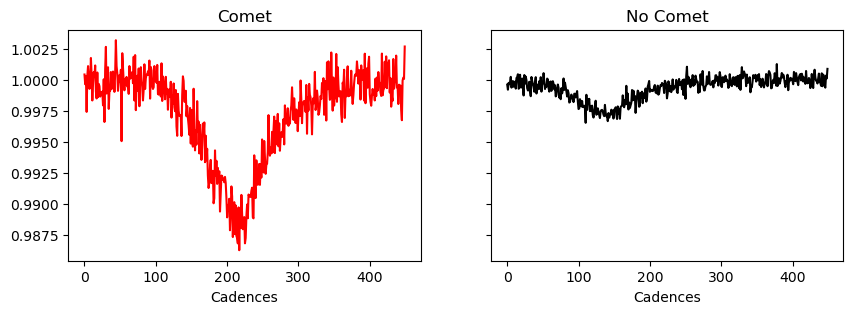

In [13]:
ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[0]], 'r')
ax1.set_title('Comet')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[0]], 'k')
ax2.set_title('No Comet')
ax2.set_xlabel('Cadences');

## Example of Exocomet Models

In [14]:
dsmodels = ds.train_data[ind_pc]

In [16]:
# num_sets = dsmodels.shape[0] // 100

# for set_index in range(num_sets):
#     start_index = set_index * 100
#     end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

#     # Create a new 10x10 grid of subplots for each set
#     fig, axs = plt.subplots(10, 10, figsize=(20, 20))

#     # Flatten the axes array for easier iteration
#     axs = axs.flatten()

#     # Iterate over the elements in the current set and plot each in the grid
#     for i in range(start_index, end_index):
#         plot_index = i % 100  # Calculate the index within the current grid
#         axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
#         axs[plot_index].set_title(f"Plot {i+1}")  # Title for each subplot

#     # Hide any remaining empty subplots
#     for j in range(end_index - start_index, len(axs)):
#         axs[j].axis('off')

    
#     plt.tight_layout()  # Adjust layout
#     plt.savefig('example-models.png',dpi=200,bbox_inches='tight')
#     plt.show()  # Show the grid of plots
#     break

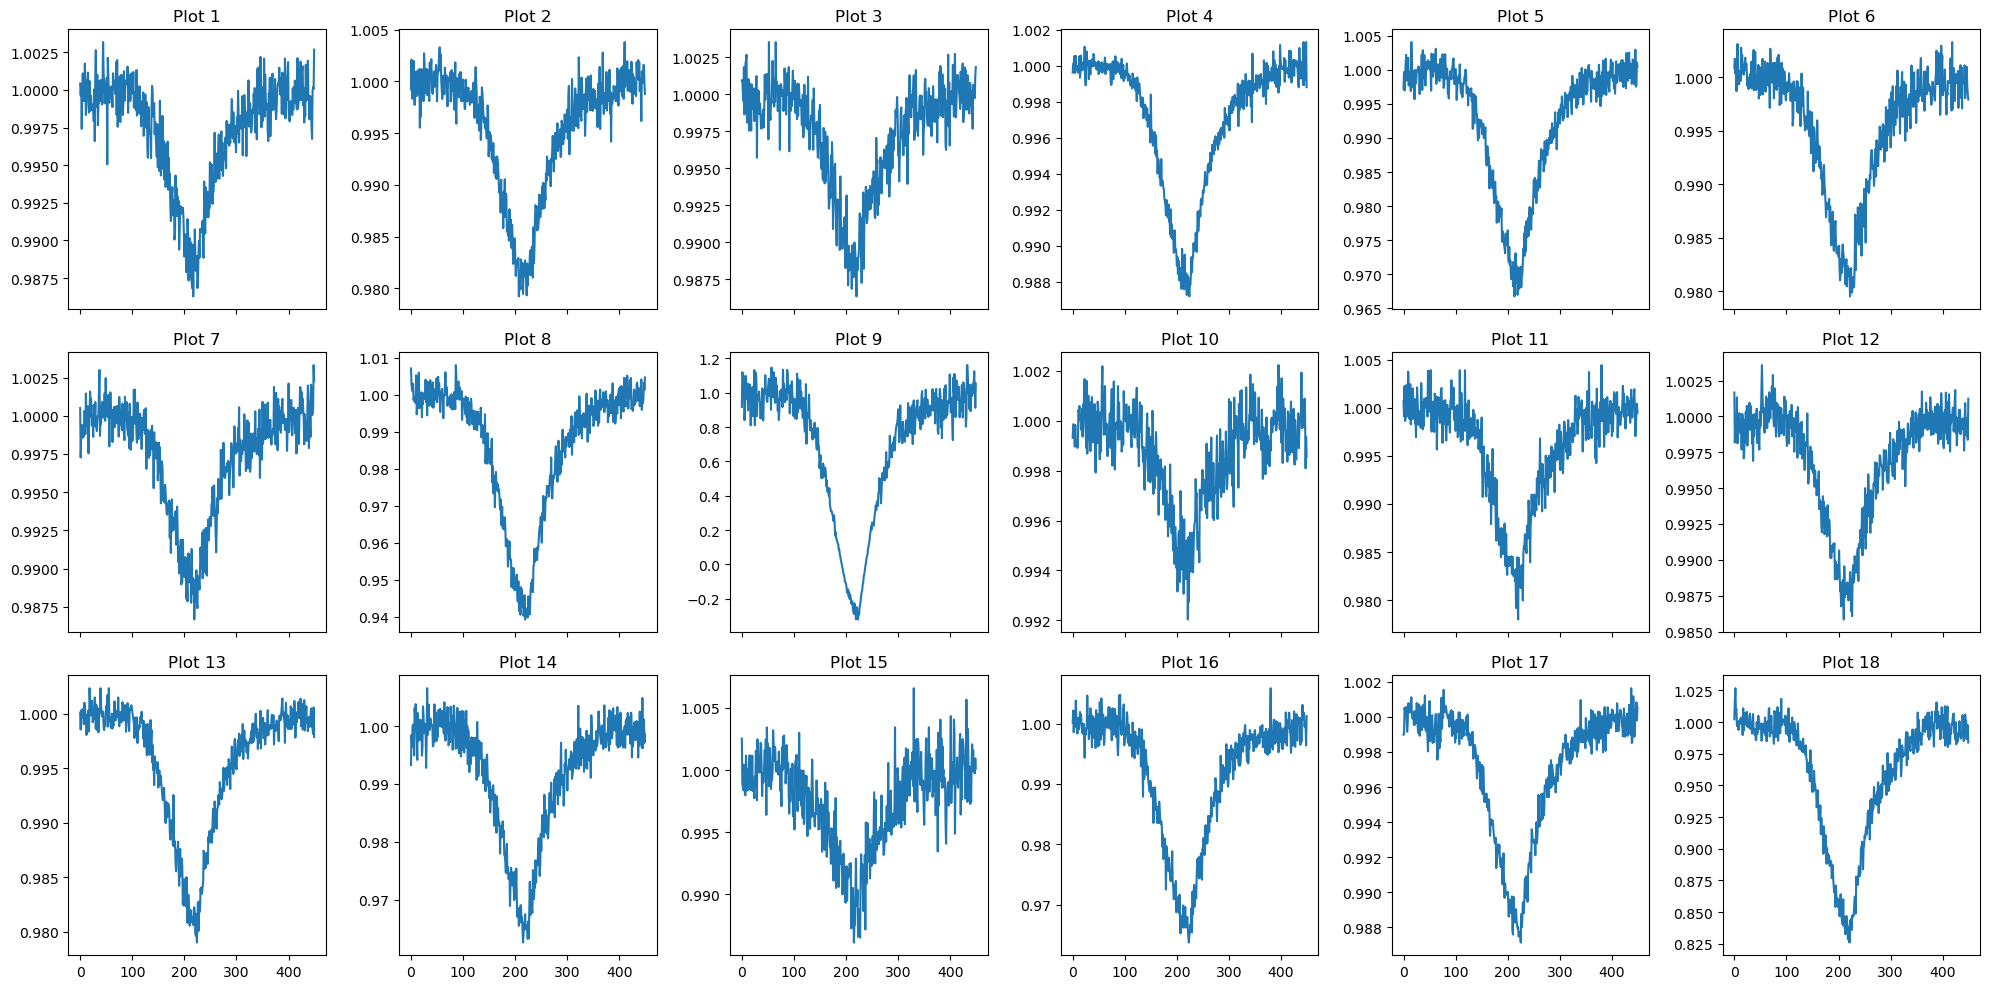

In [17]:
num_sets = dsmodels.shape[0] // 18  # Since you want a 3x6 grid

for set_index in range(num_sets):
    start_index = set_index * 18
    end_index = min((set_index + 1) * 18, dsmodels.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 3x6 grid of subplots for each set
    fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharex=True)

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 18  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i+1}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()  # Adjust layout
    plt.savefig('example-models.png', dpi=200, bbox_inches='tight')
    plt.show()  # Show the grid of plots
    break


## CNN

In [18]:
import tensorflow as tf
from tensorflow import keras

In [140]:
layers = [
    keras.layers.Conv1D(filters=16, kernel_size=10, activation='relu', padding='same', input_shape=(168, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    #keras.layers.Dropout(0.1),
    #keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    #keras.layers.MaxPooling1D(pool_size=2),
    #keras.layers.Dropout(0.1),
    
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    #keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
]

In [4]:
cnn = stella.ConvNN(output_dir='/Users/azib/Documents/open_source/nets2/cnn-models/',ds=ds) #,layers=layers)

In [5]:
cnn.train_models(seeds=20, epochs=30,batch_size=32)

2024-05-08 22:19:39.145391: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-08 22:19:39.145433: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-08 22:19:39.145444: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-08 22:19:39.145511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-08 22:19:39.145568: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 450, 16)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 225, 16)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 225, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 225, 64)           3136      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 112, 64)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 112, 64)           0

2024-05-08 22:19:40.002989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 1.2951 - accuracy: 0.5109 - precision: 0.5421 - recall: 0.7632        

2024-05-08 22:19:41.194596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 189ms/step - loss: 1.2951 - accuracy: 0.5109 - precision: 0.5421 - recall: 0.7632 - val_loss: 1.4609 - val_accuracy: 0.5294 - val_precision: 0.5294 - val_recall: 1.0000
Epoch 2/30
5/5 [==============================] - 0s 23ms/step - loss: 1.6218 - accuracy: 0.5547 - precision: 0.5547 - recall: 1.0000 - val_loss: 1.4297 - val_accuracy: 0.5294 - val_precision: 0.5294 - val_recall: 1.0000
Epoch 3/30
5/5 [==============================] - 0s 19ms/step - loss: 1.5617 - accuracy: 0.5547 - precision: 0.5547 - recall: 1.0000 - val_loss: 1.3378 - val_accuracy: 0.5294 - val_precision: 0.5294 - val_recall: 1.0000
Epoch 4/30
5/5 [==============================] - 0s 20ms/step - loss: 1.4508 - accuracy: 0.5547 - precision: 0.5547 - recall: 1.0000 - val_loss: 1.2288 - val_accuracy: 0.5294 - val_precision: 0.5294 - val_recall: 1.0000
Epoch 5/30
5/5 [==============================] - 0s 19ms/step - loss: 1.3267 - accuracy: 0.5328 - precision: 0.5455 - recall:

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-05-08 22:19:44.273340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [6]:
cnn.history_table


loss_s0020,accuracy_s0020,precision_s0020,recall_s0020,val_loss_s0020,val_accuracy_s0020,val_precision_s0020,val_recall_s0020
float64,float64,float64,float64,float64,float64,float64,float64
1.2950838804244995,0.510948896408081,0.5420560836791992,0.7631579041481018,1.4608737230300903,0.529411792755127,0.529411792755127,1.0
1.621782898902893,0.55474454164505,0.55474454164505,1.0,1.4296616315841675,0.529411792755127,0.529411792755127,1.0
1.5616861581802368,0.55474454164505,0.55474454164505,1.0,1.337827205657959,0.529411792755127,0.529411792755127,1.0
1.4508436918258667,0.55474454164505,0.55474454164505,1.0,1.2288216352462769,0.529411792755127,0.529411792755127,1.0
1.326662302017212,0.5328466892242432,0.5454545617103577,0.9473684430122375,1.119675636291504,0.529411792755127,0.529411792755127,1.0
1.205962061882019,0.5328466892242432,0.5454545617103577,0.9473684430122375,1.0188003778457642,0.529411792755127,0.529411792755127,1.0
1.098034381866455,0.5328466892242432,0.5454545617103577,0.9473684430122375,0.9311551451683044,0.529411792755127,0.529411792755127,1.0
1.0084787607192993,0.5328466892242432,0.5454545617103577,0.9473684430122375,0.8594245910644531,0.529411792755127,0.529411792755127,1.0
0.9399770498275757,0.5182482004165649,0.5403226017951965,0.8815789222717285,0.8044815063476562,0.529411792755127,0.529411792755127,1.0


In [7]:
cnn.val_pred_table


tic,gt,tpeak,pred_s0020
float64,int64,float64,float32
152877578.0,0,2079.863125179241,0.6364941
211430248.0,1,2063.995344462803,0.63623273
279424511.0,0,2066.5652189307057,0.6364274
140803080.0,1,2079.3934139785943,0.6362504
308614601.0,0,2079.856729526228,0.6365209
2028141165.0,1,2068.3493854951003,0.6306581
167247946.0,0,2063.441246634489,0.6364713
24694962.0,1,2064.6098122244025,0.6333016
348717688.0,1,2080.185747058004,0.6364043


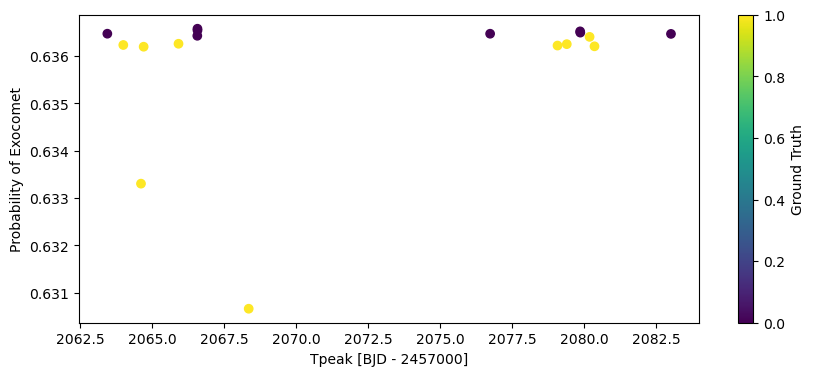

In [8]:
plt.figure(figsize=(10,4))
plt.scatter(cnn.val_pred_table['tpeak'], cnn.val_pred_table['pred_s0020'],
            c=cnn.val_pred_table['gt'], vmin=0, vmax=1)
plt.xlabel('Tpeak [BJD - 2457000]')
plt.ylabel('Probability of Exocomet')
plt.colorbar(label='Ground Truth');

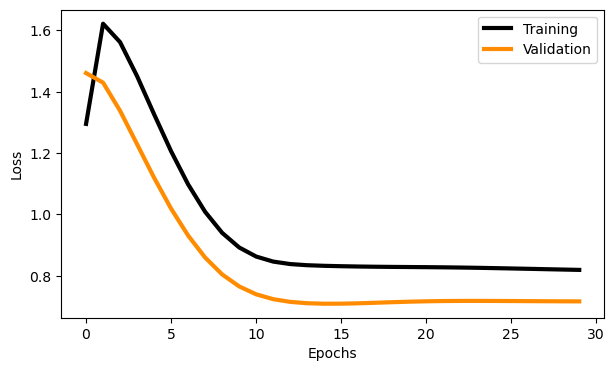

In [9]:
plt.figure(figsize=(7,4))
plt.plot(cnn.history_table['loss_s0020'], 'k', label='Training', lw=3)
plt.plot(cnn.history_table['val_loss_s0020'], 'darkorange', label='Validation', lw=3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

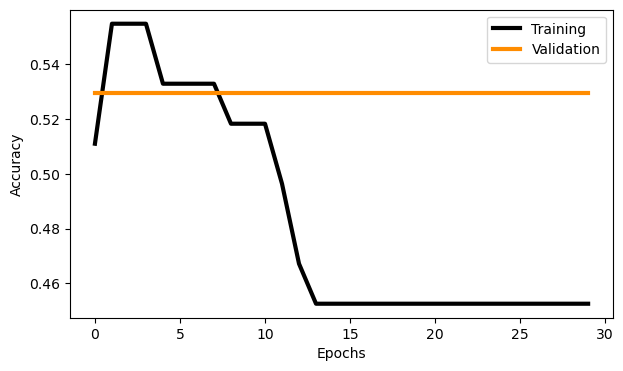

In [10]:
plt.figure(figsize=(7,4))
plt.plot(cnn.history_table['accuracy_s0020'], 'k', label='Training', lw=3)
plt.plot(cnn.history_table['val_accuracy_s0020'], 'darkorange', label='Validation', lw=3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

### Injecting two signals to test recovery

In [18]:
lcpath = random.choice(files)
lc, lc_info = import_lightcurve(f'{lcpath}')
#random_snr = np.random.uniform(min_snr,max_snr)
flat_flux = wotan.flatten(lc['TIME'], lc['SAP_FLUX'], method='median', window_length=2.5)
rms = np.std(flat_flux)
A = rms * 10

#     # Initialize a flag to indicate whether a valid time has been found
# valid_time_found = False

# while not valid_time_found:
#     t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])

#     # Check if the current random start time falls within any large gap or within 1.5 days before or after a gap
#     for index in large_gaps_indices:
#         start_time = lc['TIME'][index] - 1
#         end_time = lc['TIME'][index + 1] + 1
#         if start_time <= t0 <= end_time:
#             # Current random start time falls within a data gap or within 1.5 days before or after a gap, select a new one
#             break
#         elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(t0 - lc['TIME'][index + 1]) < 1.5:
#             # Current random start time is within 1.5 days after a data gap, select a new one
#             break
#         elif index > 0 and diff[index - 1] > 0.5 and abs(t0 - lc['TIME'][index]) < 1.5:
#             # Current random start time is within 1.5 days before a data gap, select a new one
#             break
#         elif t0 <= lc['TIME'][0] + 1:
#             # Current random start time is within one day after the beginning of the lightcurve, select a new one
#             break
#         elif t0 >= lc['TIME'][-1] - 2:
#             # Current random start time is within two days before the end of the lightcurve, select a new one
#             break
#     else:
#         # Current random start time doesn't fall within any data gap, 1.5 days before or after a gap, or special conditions, set the flag to True
#         valid_time_found = True

t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])
model = 1 - models.comet_curve(lc['TIME'], A, t0)
lc['SAP_FLUX'] = model * lc['SAP_FLUX']

B = rms * 2
model2 = 1 - models.comet_curve(lc['TIME'], B, 2080)
lc['SAP_FLUX'] = model2 * lc['SAP_FLUX']


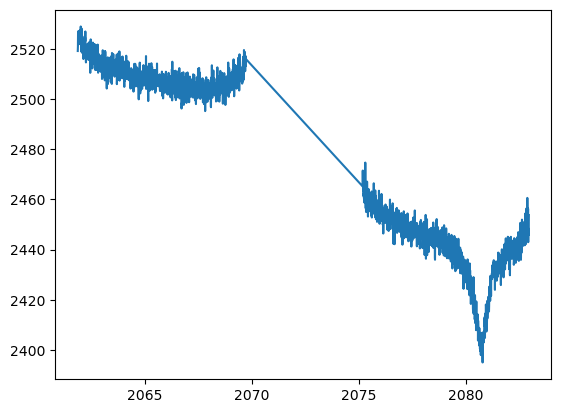

In [19]:
plt.plot(lc['TIME'],lc['SAP_FLUX'])

In [20]:
cnn.predict(modelname='/Users/azib/Documents/open_source/nets2/cnn-models/ensemble_s0018_i0020_b0.73.h5',
            times=lc['TIME'],
            fluxes=lc['SAP_FLUX'],
            errs=lc['SAP_FLUX_ERR'])

  0%|                                                                         | 0/1 [00:00<?, ?it/s]

 1/70 [..............................] - ETA: 6s

2024-05-08 22:20:12.617188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 0s 3ms/step


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Text(0, 0.5, 'Normalized Flux')

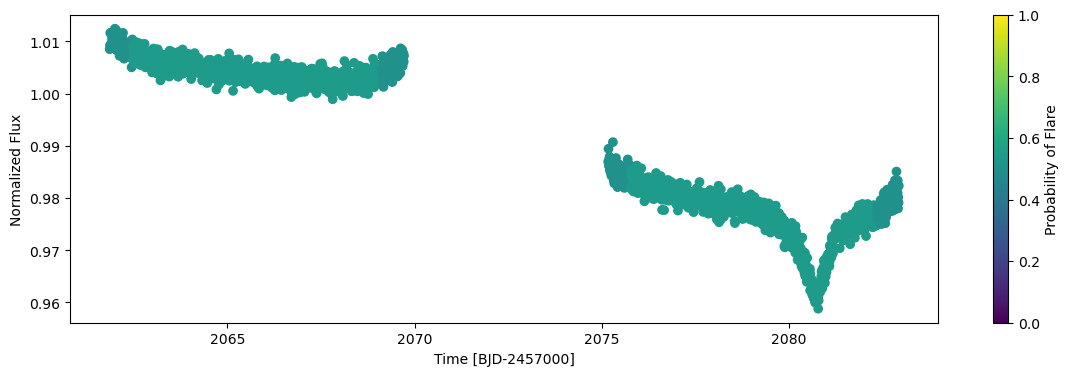

In [21]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
#plt.title('TIC {}'.format(lc.targetid));

Promising, but still more to do.

---

### Trying trasnsit with exoplanet model injected in

In [41]:
import batman

In [42]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 5                       #orbital period
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

time_diff = np.median(np.diff(lc['TIME']))
num_cadences = 450

# Calculate the total time spanned by the cadences
total_time = num_cadences * time_diff

# Calculate the start time such that the transit is centered
start_time = -total_time / 2

# Create an array of time points centered around the transit
t = np.arange(start_time, start_time + total_time, time_diff)



#t = np.arange(-1, 1 + num_cadences * time_diff, time_diff) #np.linspace(-0.025, 0.025, 500)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)

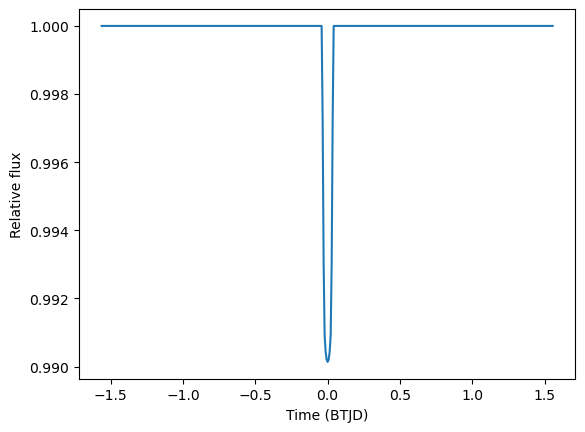

In [43]:
plt.plot(t, flux)
plt.xlabel("Time (BTJD)")
plt.ylabel("Relative flux")
plt.show()

In [44]:
#### inject the transit into a specific point in the lightcurve
lc['SAP_FLUX'] = lc['SAP_FLUX']/np.nanmedian(lc['SAP_FLUX'])
lc['SAP_FLUX'][200:650] = flux * lc[200:650]['SAP_FLUX']


# Extract the values from the smaller column
replacement_values = flux * lc[200:650]['SAP_FLUX']/np.nanmedian(lc['SAP_FLUX'])

# Replace the values in the larger column with the extracted values
lc['SAP_FLUX'][200:650] = replacement_values


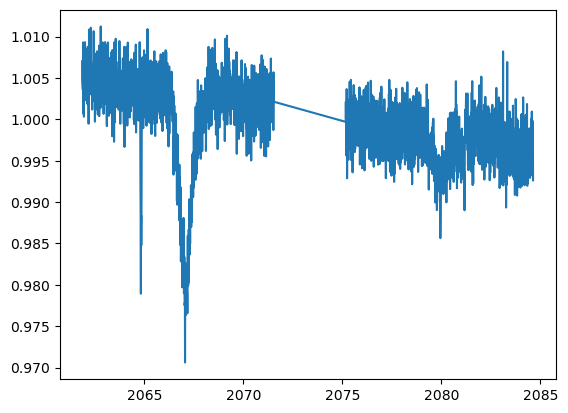

In [45]:
plt.plot(lc['TIME'],lc['SAP_FLUX'])

In [57]:
cnn.predict(modelname='/Users/azib/Documents/open_source/nets2/cnn-models/ensemble_s0042_i0100_b0.73.h5',
            times=lc['TIME'],
            fluxes=lc['SAP_FLUX'],
            errs=lc['SAP_FLUX_ERR'])

  0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]

33/86 [==========>...................] - ETA: 0s

2024-05-01 16:26:44.862223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 0s 3ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


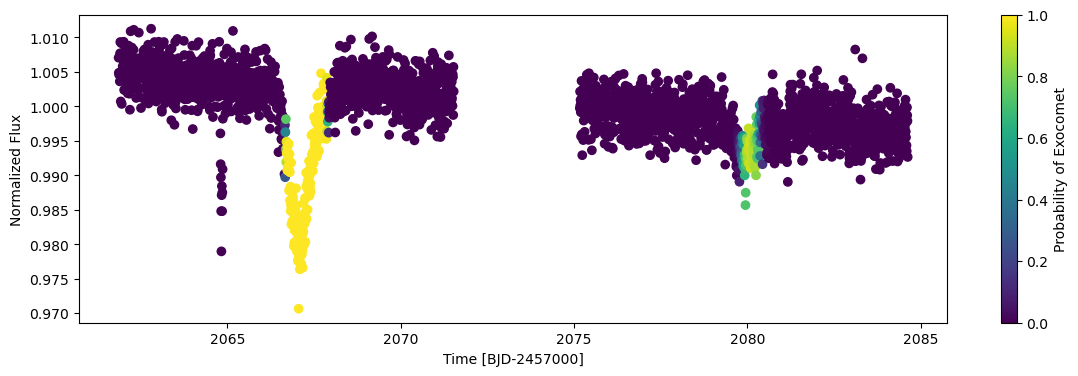

In [60]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Exocomet')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.savefig('tests.png',dpi=300,bbox_inches='tight')
#plt.title('TIC {}'.format(lc.targetid));

---

In [330]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 5                        #orbital period
params.rp = 0.4                       #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

time_diff = np.median(np.diff(lc['TIME']))
num_cadences = 450

# Calculate the total time spanned by the cadences
total_time = num_cadences * time_diff

# Calculate the start time such that the transit is centered
start_time = -total_time / 2

# Create an array of time points centered around the transit
t = np.arange(start_time, start_time + total_time, time_diff)



#t = np.arange(-1, 1 + num_cadences * time_diff, time_diff) #np.linspace(-0.025, 0.025, 500)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)

In [331]:
#### inject the transit into a specific point in the lightcurve
lc['SAP_FLUX'] = lc['SAP_FLUX']/np.nanmedian(lc['SAP_FLUX'])
lc['SAP_FLUX'][200:650] = flux * lc[200:650]['SAP_FLUX']

In [332]:

# Extract the values from the smaller column
replacement_values = flux * lc[200:650]['SAP_FLUX']/np.nanmedian(lc['SAP_FLUX'])

# Replace the values in the larger column with the extracted values
lc['SAP_FLUX'][200:650] = replacement_values


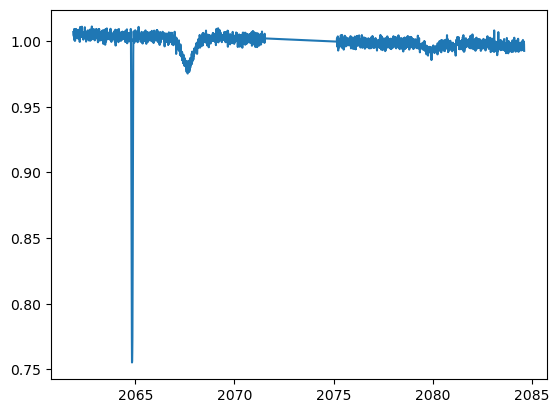

In [333]:
plt.plot(lc['TIME'],lc['SAP_FLUX'])

In [334]:
cnn.predict(modelname='/Users/azib/Documents/open_source/nets2/cnn-models/ensemble_s0042_i0100_b0.73.h5',
            times=lc['TIME'],
            fluxes=lc['SAP_FLUX'],
            errs=lc['SAP_FLUX_ERR'])

  0%|                                                                                                                                                                               | 0/1 [00:00<?, ?it/s]2024-05-01 14:06:08.472985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 1s 5ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


Text(0, 0.5, 'Normalized Flux')

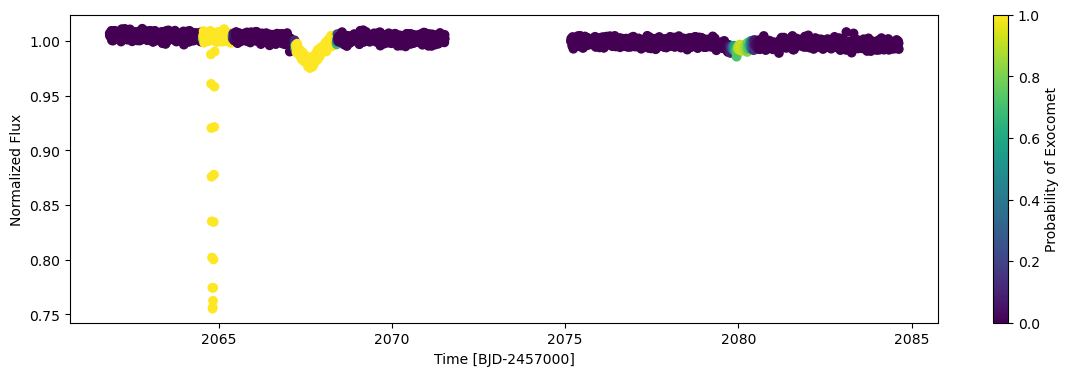

In [335]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Exocomet')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
#plt.title('TIC {}'.format(lc.targetid));